In [19]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns


In [8]:
# Step 1: Load the labeled dataset
data = pd.read_csv("data/clean_tweets_v2.csv")
data.head()

data = data[data['airline_sentiment_confidence'] == 1].reset_index()
data.shape


(10445, 17)

In [9]:
# STEP 2: Tweet cleaning was done in separate notebook

# STEP 3: Split the data into training and testing sets
X = data['clean_tweets']  # 'text' 
y = data['airline_sentiment']  # 'sentiment' is the column containing labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# STEP 4: Feature Extraction 

# ML algorithms operate on numerical data and not words. 
# Countvectorizer is a method to convert text to numerical data 
# using a Bag of Words Approach

# You can adjust max_features as needed
vectorizer = CountVectorizer(max_features=4450)

# alternative technique for feature extraction
# tfidf_vectorizer = TfidfVectorizer(max_features=4450) 

# convert dtype to unicode string by using apply function
X_train_text = vectorizer.fit_transform(X_train.apply(lambda X_train_text: np.str_(X_train_text)))
X_test_text = vectorizer.transform(X_test.apply(lambda X_test_text: np.str_(X_test_text)))


In [10]:
# STEP 5: Model Selection (Multinomial Naive Bayes)
naive_bayes = MultinomialNB(alpha=0.1)


In [11]:
# STEP 6: Model Training
naive_bayes.fit(X_train_text, y_train)


MultinomialNB(alpha=0.1)

              precision    recall  f1-score   support

    negative       0.89      0.95      0.92       755
     neutral       0.72      0.46      0.56       146
    positive       0.84      0.82      0.83       144

    accuracy                           0.87      1045
   macro avg       0.82      0.74      0.77      1045
weighted avg       0.86      0.87      0.86      1045

Model accuracy: 0.8660287081339713


<Axes: title={'center': 'Sentiment Confusion Matrix'}, xlabel='Predicted Sentiment', ylabel='Actual Sentiment'>

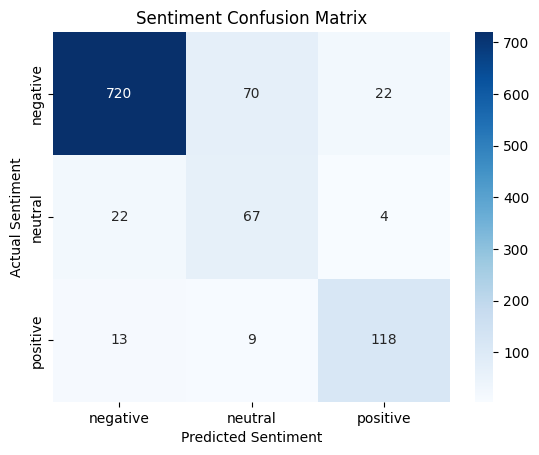

In [39]:
# STEP 7: Model Evaluation
y_pred = naive_bayes.predict(X_test_text)
print(classification_report(y_test, y_pred))

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict)
report_df = report_df.T
report_df.loc['accuracy',['precision', 'recall']] = [np.nan, np.nan]

print('Model accuracy: {}'.format(report_df.loc['accuracy', 'f1-score']))
# report_df.to_excel('report.xlsx', index=False)

# Create heatmap/confusion matrix
conf_matrix = confusion_matrix(y_pred, y_test)
conf_matrix

map = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')

map.set_title('Sentiment Confusion Matrix');
map.set_xlabel('Predicted Sentiment')
map.set_ylabel('Actual Sentiment');

map.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
map.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])

map


In [15]:
from collections import Counter

# Assuming y_train is your target variable
class_counts = Counter(y_pred)
print(class_counts)
print(y_pred[:10])

Counter({'negative': 812, 'positive': 140, 'neutral': 93})
['negative' 'neutral' 'negative' 'negative' 'neutral' 'negative'
 'negative' 'negative' 'positive' 'negative']


In [161]:
# Ran this cell to find best parameters
# Plugged in parameters to model above

accuracies = []
params = []

# Finding best value for max_features in loop below

for i in range(100, 5000, 25):
    # ML algorithms operate on numerical data and not words. 
    # Countvectorizer is a method to convert text to numerical data 
    # using a Bag of Words Approach
    # You can adjust max_features as needed
    vectorizer = CountVectorizer(max_features=i)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
   
    X_train_text = vectorizer.fit_transform(X_train.apply(lambda X_train_text: np.str_(X_train_text)))
    X_test_text = vectorizer.transform(X_test.apply(lambda X_test_text: np.str_(X_test_text)))
    
    naive_bayes = MultinomialNB()
    
    # Define the parameter grid to search
    param_grid = {
        'alpha': [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5, 1.7, 2.0, 2.5, 3.0], 
    }
    
    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=10, scoring='accuracy')
    
    # Fit the model with the dataset
    grid_search.fit(X_train_text, y_train)
    
    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    params.append(best_params)
    accuracies.append(best_score)
    
        

In [162]:
max_index = accuracies.index(max(accuracies))
num_features = (max_index+4)*25
print('num_features {}'.format(num_features))
print('max k-fold accuracy {}'.format(accuracies[max_index]))
print(params[max_index])

num_features 4450
max k-fold accuracy 0.8468085106382979
{'alpha': 0.1}
